# Continous Variables Quantum state tomography (QST) with Gradient descent (GD)

This notebook is a demonstration of using the different GD methods to do QST. For that demonstration we will show the case of a cat state with $\alpha=2$

$$ | \psi_{cat} \rangle = \frac{1}{\mathcal{N}} (| \alpha \rangle + | -\alpha \rangle)$$

In [3]:
import sys

sys.path.insert(0, '..')
import os

import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp
from qutip import basis, tensor
from qutip import coherent, coherent_dm, expect, Qobj, fidelity, rand_dm
from qutip.wigner import wigner, qfunc
from qutip.visualization import hinton, plot_wigner

# Libraries for the different methods of doing QST with GD
from qst_tec.gdchol_triangular import gd_chol_triangular, cholesky_f, rho_cons
from qst_tec.gdchol_rank import gd_chol_rank
from qst_tec.gdmanifold import gd_manifold, mix_rho, Nkets, softmax, expect_prob_ket
from qst_tec.gdmanifold_adaptive import gd_manifold_adaptive, mix_rho, Nkets, softmax, expect_prob_ket
from qst_tec.gdproj import gd_project
from qst_tec.least_square import least_square_qst
from qst_tec.compressed_sensing import compressed_sensing_qst
from qst_tec.mlefu import mle_CV



import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
jax.config.update("jax_enable_x64", True)
import optax

from tqdm import tqdm
import time

#  ----- for the qst-cgan -------------------------------------------------------------
import tensorflow as tf
from qst_tec.medium_gan import train_GAN, Generator, Discriminator
from qst_tec.ops import convert_to_real_ops, batched_expect, dm_to_tf


%load_ext autoreload
%autoreload 2


/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
tf.keras.backend.set_floatx('float64')
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Defining the hilbert space  and the measurement operators, in this case is with the Husimi Q function measurements

$$ \mathcal{O}_{i} = \frac{1}{\pi} | \beta_i \rangle \langle \beta_{i} | $$

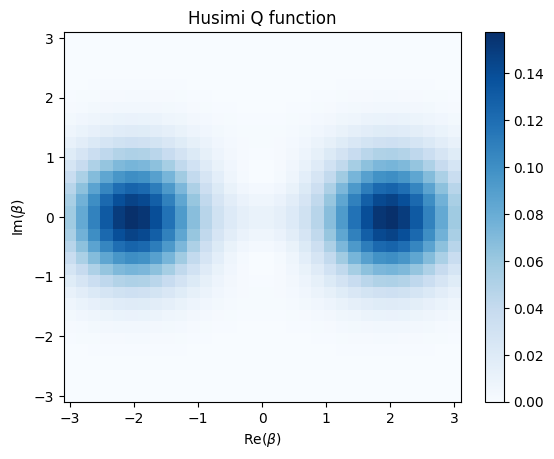

In [5]:
hilbert_size: int = 32
alpha = 2
HS: int = hilbert_size
kn: int = 1

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace

grid = 32
xvec = np.linspace(-3, 3, grid)
yvec = np.linspace(-3, 3, grid)

q = qfunc(psi, xvec, yvec, g=2)

cmap = "Blues"
im = plt.pcolor(xvec, yvec, q, vmin=0, vmax=np.max(q), cmap=cmap, shading='auto')
plt.colorbar(im)
plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function")
plt.show()

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

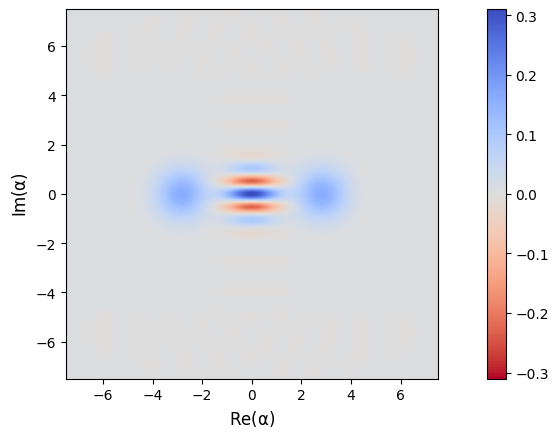

In [6]:
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = [coherent_dm(hilbert_size, beta) for beta in betas]
ops_numpy = [op.full() for op in m_ops]
ops_jnp = jnp.asarray(ops_numpy)

data = qtp.expect(m_ops, psi)
rho_or = psi*psi.dag()


plot_wigner(rho_or, colorbar=True, cmap='coolwarm_r')

## The ansatz

For each one of the GD methods the creation of the ansatz is different, for the specific shape and structure of the ansatz go to the paper or check the other notebooks that shows the ansatz of each case.  

In [7]:
def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the different GD methods
    
    Args: 
        kn (int) : rank number
    
    Output:
        T_rank : Ansatz GD-Cholesky rank
        T_triangular : Ansatz GD-Cholesky triangular
        column_ket_pro : Ansatz GD-manifold
        ket_f, prob1_array_jnp : Ansatz GD-projective 
        
    """
    
    # T_rank  = arbitrary r x p matrix ansatz for Cholesky
    real_part = np.random.rand(kn, HS)  # Random numbers from a uniform distribution over [0, 1)
    imaginary_part = np.random.rand(kn, HS)  # Same for the imaginary part
    guess = real_part + 1j * imaginary_part
    T_rank = jnp.asarray(guess)

    # T_triangular Lower traingular matrix ansatz for Cholesky
    T_triangular = jnp.asarray(rho_cons(np.random.rand(HS, HS) + 1j*np.random.rand(HS, HS)))

    ketl1 = Nkets(kn, HS)   # generate kn random kets with hilbert space HS
    ketl1_np = [a.full() for a in ketl1]
    ketl2 = [a.full().flatten() for a in ketl1]
    ketl2_np = np.asarray(ketl2)
    ketl2_jnp = jnp.asarray(ketl2)
    ketl1_jnp = jnp.asarray(ketl1_np)
    prob1_array = np.random.rand(kn) # create the second list for the random probabilities
    prob1_array = softmax(prob1_array)
    prob1_array_jnp = jnp.asarray(prob1_array)
    mixed_density = 0
    for i in range(len(ketl1)): # to create the density matrix
        density_i = ketl1[i]*ketl1[i].dag()
        mixed_density += prob1_array[i]*density_i
    
    rho_ran = mixed_density
    rho_ran_np = rho_ran.full()
    
    # --- the rho for mle ---------------------------------------- 
    rho_mle = [r[:] for r in rho_ran_np]
    rho_mle = qtp.Qobj(rho_mle)

    # --- kets for GD proj -------------------------------------
    ket_f = ketl1_jnp.flatten()
    ket_f = ket_f[:, jnp.newaxis]

    # --- column ket for GD manifold ------------------------
    prob_sqrt = jnp.sqrt(prob1_array_jnp) 
    prob1_array_reshaped = prob_sqrt[:, jnp.newaxis]
    ket_prob_o = prob1_array_reshaped * ketl2_jnp 
    ket_prob = ket_prob_o.flatten()
    column_ket_pro = ket_prob[:, np.newaxis]

    return T_rank, T_triangular, column_ket_pro, ket_f, prob1_array_jnp, rho_mle

In [8]:
#------ initial rho dat ----------------------------------
data = qtp.expect(m_ops,rho_or)


# ----- for cgan the measurement operators ---------------------------------------
ops = dm_to_tf(m_ops)
ops_batch = tf.convert_to_tensor([ops])
rhos = dm_to_tf([rho_or])
x = batched_expect(ops_batch, rhos)
A = convert_to_real_ops(ops_batch)

In [9]:
fid_list_chol_rank, fid_list_chol_triangular, fid_list_mani, fid_list_mani_adaptive, fid_list_proj = [], [], [], [], []
time_list_chol_rank, time_list_chol_triangular, time_list_mani, time_list_mani_adaptive, time_list_proj = [], [], [], [], []

fid_list_cgan, time_list_cgan = [], []
fid_list_mle, time_list_mle = [], []



ver1 = 0
max_itera = 1000     # 10000
batch_s = round(0.55 * len(ops_jnp)) #len(ops_jnp) - 10 
itera_cgan = 1000

for i in range(1):

     rho_T, rho, column_ket_pro, ket_f, prob1_array_jnp, rho_mle = ansatz(1)

     rho_gd_mani, f_gd_mani, t_gd_mani, loss_gd_m = gd_manifold(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                            lr=5e-2, decay=0.999, lamb=0.001)
                                                                 # 0.0000001
     
     fid_list_mani.append(f_gd_mani)
     time_list_mani.append(t_gd_mani)


     rho_gd_chol_rank, f_gd_chol_rank, t_gd_chol_rank, _ = gd_chol_rank(data, rho_or, ops_jnp, rho_T, max_itera, batch_s, 
                                                  lr=1e-1, decay = 0.999 ,lamb=1e-9)
     fid_list_chol_rank.append(f_gd_chol_rank)
     time_list_chol_rank.append(t_gd_chol_rank)
     
    
     rho_mle, f_mle, t_mle = mle_CV(data, rho_or, m_ops, rho_mle, max_itera)
     
     fid_list_mle.append(f_mle)
     time_list_mle.append(t_mle)

     
     
     rho_gd_proj, f_gd_proj, t_gd_proj, loss_gd_proj = gd_project(data, rho_or, ops_jnp, ket_f, prob1_array_jnp, max_itera, batch_s,
                                                                 lr=5e-2, decay=0.009, lamb=0.0001)

     fid_list_proj.append(f_gd_proj)
     time_list_proj.append(t_gd_proj)
    
     log_interval = 20
     tol = 1e-9

     
     f_gan, model_dm, states_gan, t_cgan = train_GAN(A, x, rho_or, tol=tol,
                                             max_iterations = itera_cgan,
                                             log_interval=log_interval, noise=0)
     
     fid_list_cgan.append(f_gan)
     time_list_cgan.append(t_cgan)

Fidelity0.9995456920740702: 100%|██████████| 1000/1000 [01:43<00:00,  9.69it/s]


In [10]:

fid_list_chol_rank = np.array(fid_list_chol_rank)
# fid_list_chol_triangular = np.array(fid_list_chol_triangular)
fid_list_mani = np.array(fid_list_mani)
fid_list_mani_adaptive = np.array(fid_list_mani_adaptive)
fid_list_proj = np.array(fid_list_proj)
fid_list_cgan = np.array(fid_list_cgan)
fid_list_mle = np.array(fid_list_mle)


# Compute mean fidelity
mean_fid_chol_rank = np.mean(fid_list_chol_rank, axis=0)
# mean_fid_chol_triangular = np.mean(fid_list_chol_triangular, axis=0)
mean_fid_mani = np.mean(fid_list_mani, axis=0)
mean_fid_mani_adaptive = np.mean(fid_list_mani_adaptive, axis=0)
mean_fid_proj = np.mean(fid_list_proj, axis=0)
mean_fid_cgan = np.mean(fid_list_cgan, axis=0)
mean_fid_mle = np.mean(fid_list_mle, axis=0)


# Compute standard deviation in the mean fidelity
std_fid_chol_rank = np.std(fid_list_chol_rank, axis=0)
# std_fid_chol_triangular = np.std(fid_list_chol_triangular, axis=0)
std_fid_mani = np.std(fid_list_mani, axis=0)
std_fid_mani_adaptive = np.std(fid_list_mani_adaptive, axis=0)
std_fid_proj = np.std(fid_list_proj, axis=0)
std_fid_cgan = np.std(fid_list_cgan, axis=0)
std_fid_mle = np.std(fid_list_mle, axis=0)




########################### Average time ###################

time_list_chol_rank = np.array(time_list_chol_rank)
# time_list_chol_triangular = np.array(time_list_chol_triangular)
time_list_mani = np.array(time_list_mani)
time_list_mani_adaptive = np.array(time_list_mani_adaptive)
time_list_proj = np.array(time_list_proj)
time_list_cgan = np.array(time_list_cgan)
time_list_mle = np.array(time_list_mle)


# Compute mean fidelity
mean_time_chol_rank = np.mean(time_list_chol_rank, axis=0)
# mean_time_chol_triangular = np.mean(time_list_chol_triangular, axis=0)
mean_time_mani = np.mean(time_list_mani, axis=0)
mean_time_mani_adaptive = np.mean(time_list_mani_adaptive, axis=0)
mean_time_proj = np.mean(time_list_proj, axis=0)
mean_time_cgan = np.mean(time_list_cgan, axis=0)
mean_time_mle = np.mean(time_list_mle, axis=0)


# Compute standard deviation in the mean fidelity
std_time_chol_rank = np.std(time_list_chol_rank, axis=0)
# std_time_chol_triangular = np.std(time_list_chol_triangular, axis=0)
std_time_mani = np.std(time_list_mani, axis=0)
std_time_mani_adaptive = np.std(time_list_mani_adaptive, axis=0)
std_time_proj = np.std(time_list_proj, axis=0)
std_time_cgan = np.std(time_list_cgan, axis=0)
std_time_mle = np.std(time_list_mle, axis=0)



/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/gd_qst_env_m1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


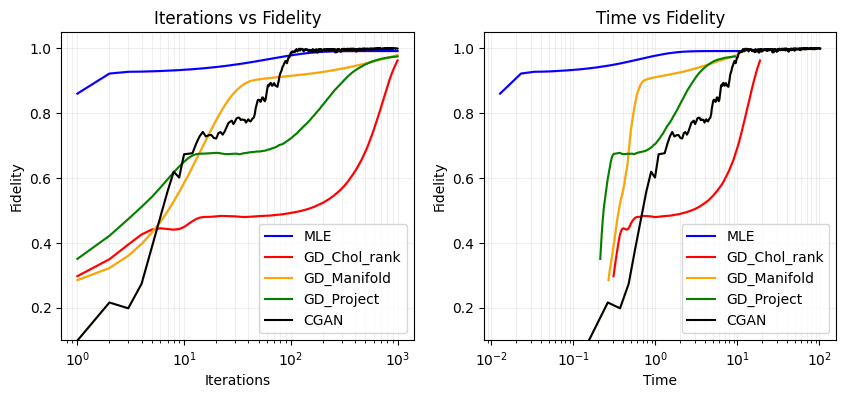

In [11]:

# f_gan.pop(0)
iterations = np.arange(1,len(f_gd_chol_rank)+1)   # total number of iterations


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.set_title("Iterations vs Fidelity", fontsize=12)


ax1.plot(iterations, mean_fid_mle[1:], color="blue", label="MLE")
ax1.fill_between(iterations, mean_fid_mle[1:] - std_fid_mle[1:], mean_fid_mle[1:] + std_fid_mle[1:], alpha=0.2, color='red')

ax1.plot(iterations, mean_fid_chol_rank, color="red", label="GD_Chol_rank")
ax1.fill_between(iterations, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')


ax1.plot(iterations, mean_fid_mani, color="orange", label="GD_Manifold")
ax1.fill_between(iterations, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax1.plot(iterations, mean_fid_proj, color="green", label="GD_Project")
ax1.fill_between(iterations, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')

ax1.plot(iterations[:1000], mean_fid_cgan, color="black", label="CGAN")
ax1.fill_between(iterations[:1000], mean_fid_cgan - std_fid_cgan, mean_fid_cgan + std_fid_cgan, alpha=0.2, color='orange')

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")
ax1.set_ylim(0.1, 1.05)
# plt.xlim(90,20000)
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.2)
ax1.set_xscale('log')

###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_mle, mean_fid_mle[1:], color="blue", label="MLE")
ax2.fill_between(mean_time_mle, mean_fid_mle[1:] - std_fid_mle[1:], mean_fid_mle[1:] + std_fid_mle[1:], alpha=0.2, color='red')

ax2.plot(mean_time_chol_rank, mean_fid_chol_rank, color="red", label="GD_Chol_rank")
ax2.fill_between(mean_time_chol_rank, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')


ax2.plot(mean_time_mani, mean_fid_mani, color="orange", label="GD_Manifold")
ax2.fill_between(mean_time_mani, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax2.plot(mean_time_proj, mean_fid_proj, color="green", label="GD_Project")
ax2.fill_between(mean_time_proj, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')

ax2.plot(mean_time_cgan, mean_fid_cgan, color="black", label="CGAN")
ax2.fill_between(mean_time_cgan, mean_fid_cgan - std_fid_cgan, mean_fid_cgan + std_fid_cgan, alpha=0.2, color='orange')

ax2.legend(loc='lower right')
ax2.set_xlabel("Time")
ax2.set_ylabel("Fidelity")
ax2.set_ylim(0.1, 1.05)
# plt.xlim(90,20000)
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.2)
ax2.set_xscale('log')


plt.show()